# Forest Cover Type — EDA, Modeling, Feature Reduction, and Interpretation

This notebook performs exploratory data analysis, trains and evaluates several classifiers with cross-validation, applies RFE and PCA for dimensionality reduction, and provides visual interpretations and a recommendation for national forest monitoring.

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

In [2]:
# Load dataset (UCI Covertype) and downsample to ~5000 rows
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
cols = []
# 10 quantitative attributes
quant = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
         'Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
# 4 Wilderness areas (binary)
wilderness = [f'Wilderness_Area{i}' for i in range(1,5)]
# 40 Soil types (binary)
soil = [f'Soil_Type{i}' for i in range(1,41)]
cols = quant + wilderness + soil + ['Cover_Type']
df = pd.read_csv(url, header=None, names=cols, compression='gzip')
print('Original shape:', df.shape)
# Downsample (stratified sample to preserve class proportions)
df_sample = df.groupby('Cover_Type', group_keys=False).apply(lambda x: x.sample(min(len(x), 800), random_state=42)).sample(n=5000, random_state=42) if df.shape[0] > 5000 else df.copy()
df_sample = df_sample.reset_index(drop=True)
print('Sampled shape:', df_sample.shape)

Original shape: (581012, 55)
Sampled shape: (5000, 55)


In [3]:
# Quick look
df_sample.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2618,309,16,270,100,1087,175,228,193,1765,...,0,1,0,0,0,0,0,0,0,6
1,2544,333,24,108,22,1358,158,201,178,1323,...,0,0,0,0,0,0,0,0,0,6
2,2377,119,17,201,86,1237,246,223,100,1006,...,0,0,0,0,0,0,0,0,0,3
3,2288,31,7,0,0,488,218,225,143,830,...,0,0,0,0,0,0,0,0,0,4
4,2262,26,6,0,0,721,217,227,146,646,...,0,0,0,0,0,0,0,0,0,4


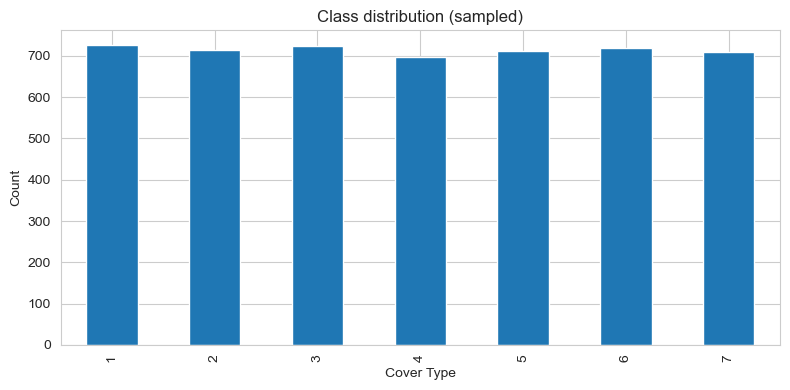

In [4]:
# Class distribution
plt.figure(figsize=(8,4))
ax = df_sample['Cover_Type'].value_counts().sort_index().plot(kind='bar')
ax.set_xlabel('Cover Type')
ax.set_ylabel('Count')
ax.set_title('Class distribution (sampled)')
plt.tight_layout()
plt.show()

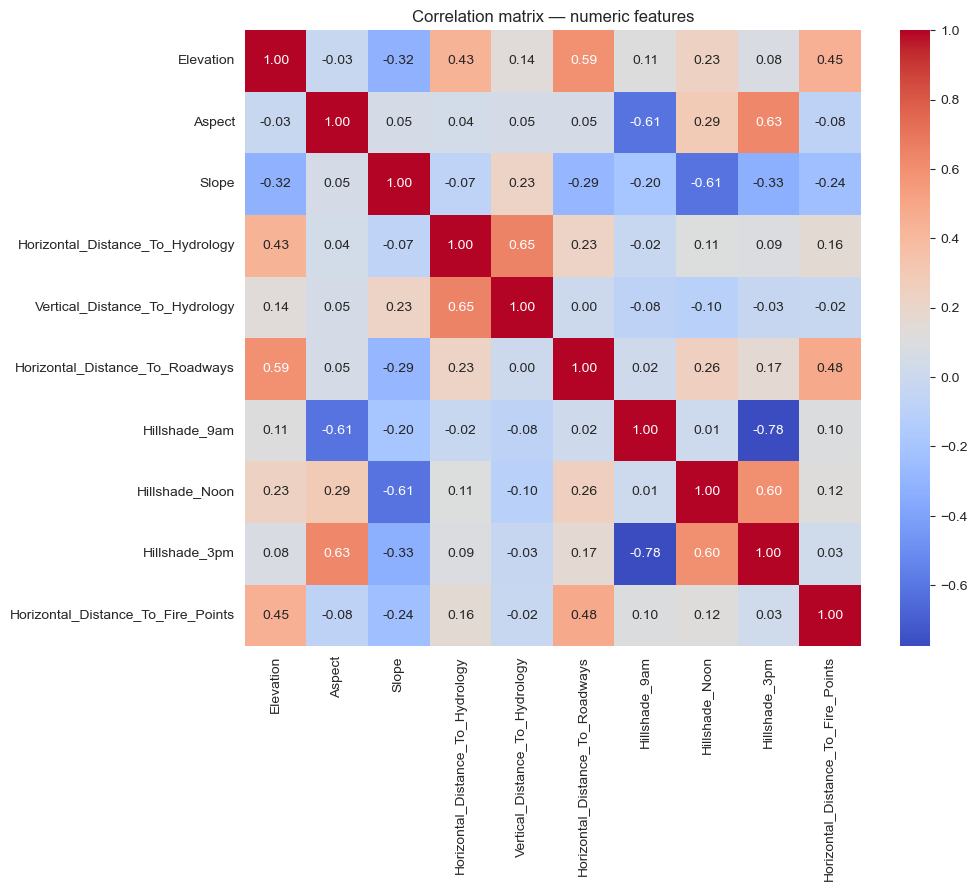

In [5]:
# Correlation analysis (numeric features)
num_feats = quant
corr = df_sample[num_feats].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation matrix — numeric features')
plt.show()

## Feature distributions (numeric features)
Visualize a subset of numeric feature distributions to inspect skew and ranges.

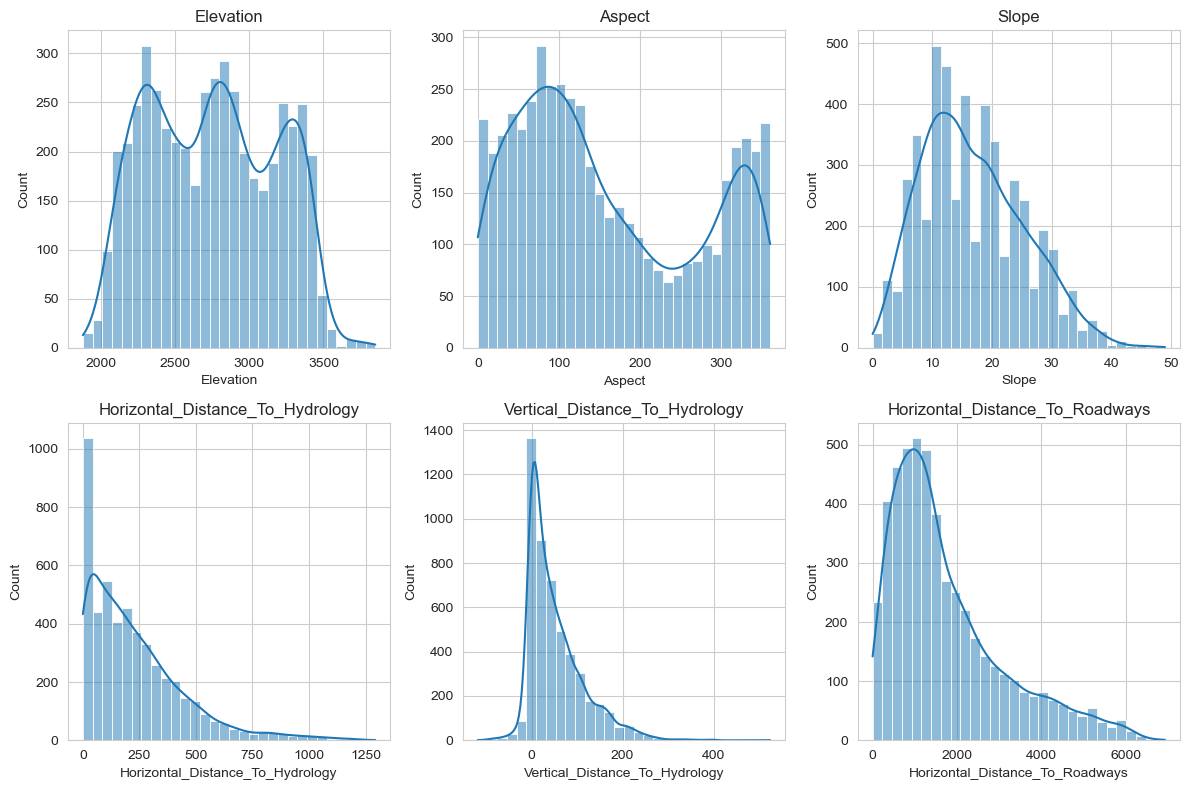

In [6]:
plt.figure(figsize=(12,8))
for i, f in enumerate(num_feats[:6], 1):
    plt.subplot(2,3,i)
    sns.histplot(df_sample[f], bins=30, kde=True)
    plt.title(f)
plt.tight_layout()
plt.show()

## Modeling: cross-validated evaluation
We'll evaluate Logistic Regression, KNN, Decision Tree, and Random Forest using stratified 5-fold cross-validation. Metrics: accuracy and macro F1.

In [7]:
X = df_sample.drop('Cover_Type', axis=1)
y = df_sample['Cover_Type']
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = {
    'LogisticRegression': Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs'))]),
    'KNN': Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier(n_neighbors=7))]),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}
results = []
for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=skf, scoring='accuracy', n_jobs=-1)
    f1 = cross_val_score(model, X, y, cv=skf, scoring='f1_macro', n_jobs=-1)
    results.append({'model': name, 'accuracy_mean': acc.mean(), 'accuracy_std': acc.std(), 'f1_macro_mean': f1.mean(), 'f1_macro_std': f1.std()})
res_df = pd.DataFrame(results).sort_values('f1_macro_mean', ascending=False)
res_df

,model,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std
3,RandomForest,0.8078,0.014372,0.805542,0.015126
2,DecisionTree,0.7192,0.011016,0.718253,0.011056
1,KNN,0.7052,0.009558,0.701402,0.009358
0,LogisticRegression,0.6886,0.014746,0.686050,0.015674


## Confusion matrices (cross-validated predictions)
Compute cross-validated predictions using `cross_val_predict` and plot confusion matrices for each model to inspect error patterns.

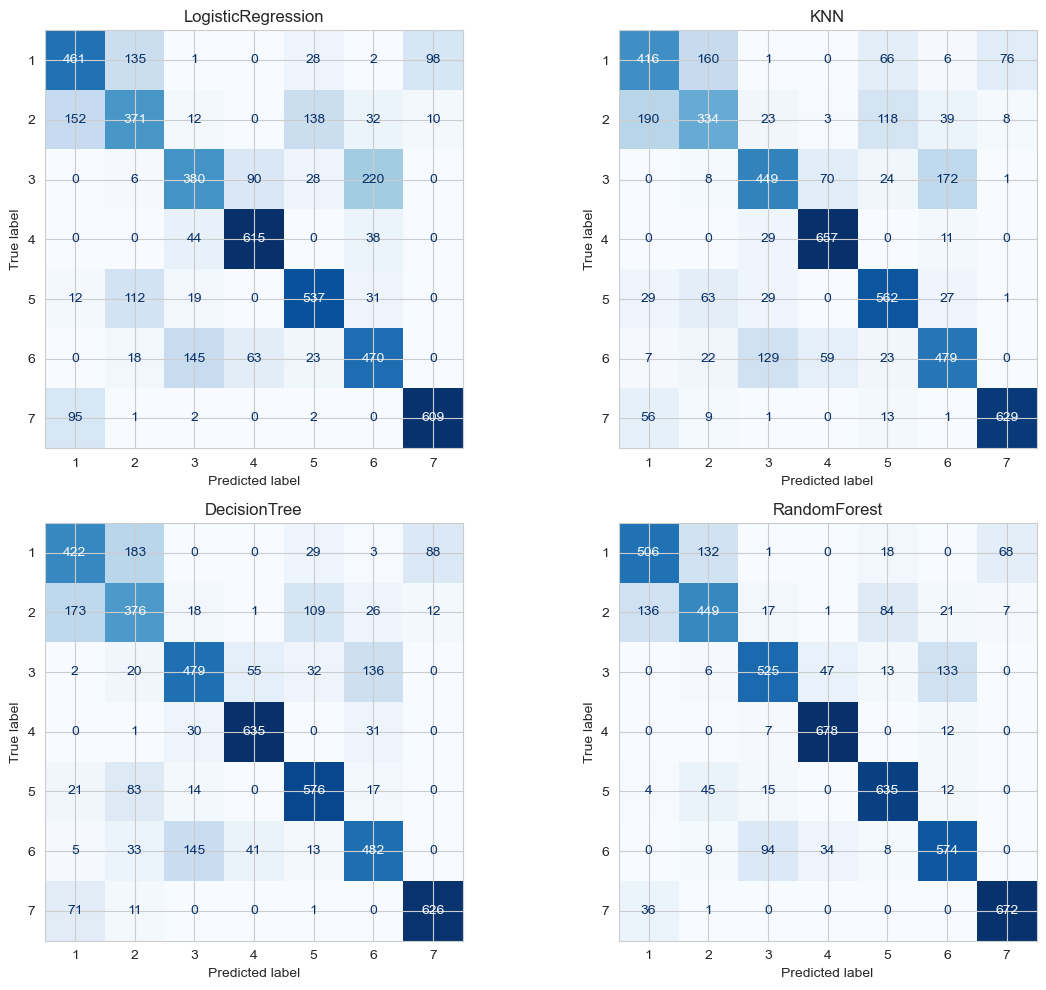

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.figure(figsize=(12,10))
for i, (name, model) in enumerate(models.items(), 1):
    y_pred = cross_val_predict(model, X, y, cv=skf, n_jobs=-1)
    cm = confusion_matrix(y, y_pred, labels=sorted(y.unique()))
    plt.subplot(2,2,i)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y.unique()))
    disp.plot(ax=plt.gca(), cmap='Blues', colorbar=False)
    plt.title(name)
plt.tight_layout()
plt.show()

## Feature importances — Decision Tree & Random Forest
Fit tree-based models on the full sampled dataset and visualize the top features by importance.

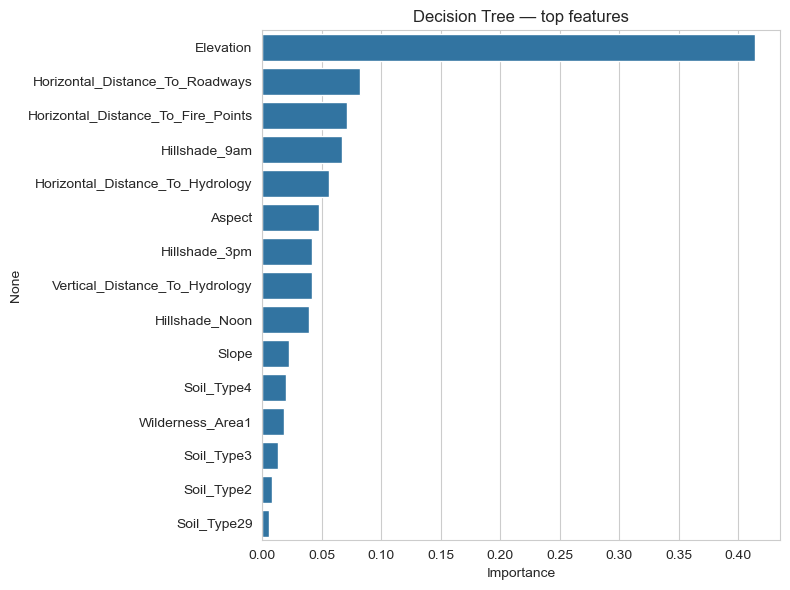

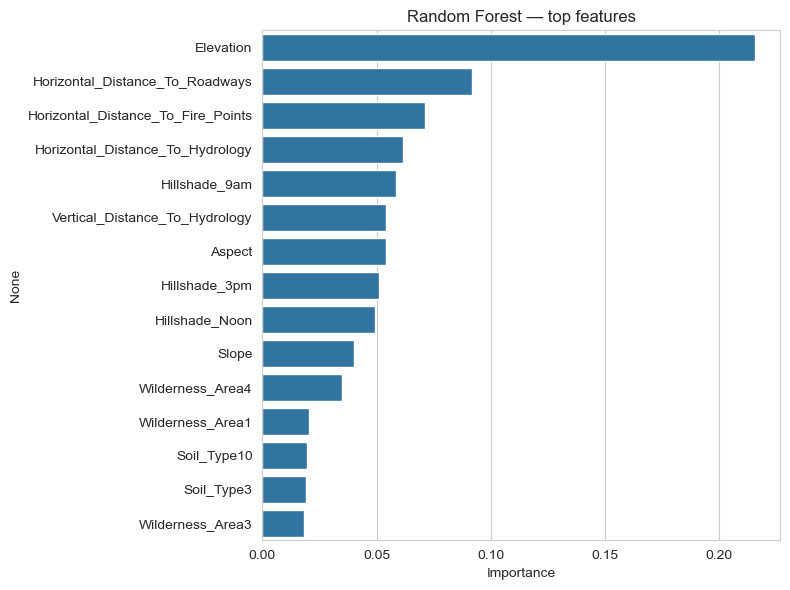

In [9]:
# Fit Decision Tree and Random Forest on full sample
dt = DecisionTreeClassifier(random_state=42).fit(X, y)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1).fit(X, y)
# Helper to plot top-k importances
def plot_importances(importances, features, title, k=15):
    imp_df = pd.Series(importances, index=features).sort_values(ascending=False).head(k)
    plt.figure(figsize=(8,6))
    sns.barplot(x=imp_df.values, y=imp_df.index)
    plt.title(title)
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
plot_importances(dt.feature_importances_, X.columns, 'Decision Tree — top features')
plot_importances(rf.feature_importances_, X.columns, 'Random Forest — top features')

## Recursive Feature Elimination (RFE)
Use RFE with Random Forest to select a reduced feature set and evaluate how model performance changes.

In [10]:
# RFE with RandomForest (select top 15 features)
est = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rfe = RFE(estimator=est, n_features_to_select=15, step=1)
rfe.fit(X, y)
selected = X.columns[rfe.support_]
print('Selected features (15):')
print(list(selected))
# Evaluate RandomForest on reduced features via CV
acc_full = cross_val_score(est, X, y, cv=skf, scoring='accuracy', n_jobs=-1).mean()
acc_rfe = cross_val_score(est, X[selected], y, cv=skf, scoring='accuracy', n_jobs=-1).mean()
f1_full = cross_val_score(est, X, y, cv=skf, scoring='f1_macro', n_jobs=-1).mean()
f1_rfe = cross_val_score(est, X[selected], y, cv=skf, scoring='f1_macro', n_jobs=-1).mean()
pd.DataFrame([{'setting':'full','accuracy':acc_full,'f1_macro':f1_full},{'setting':'rfe_15','accuracy':acc_rfe,'f1_macro':f1_rfe}])

Selected features (15):
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type3', 'Soil_Type10']


,setting,accuracy,f1_macro
0,full,0.8078,0.805542
1,rfe_15,0.7904,0.787124


## PCA — 2D scatter plot
Standardize numeric features and project data into 2 principal components for visualization of class separation.

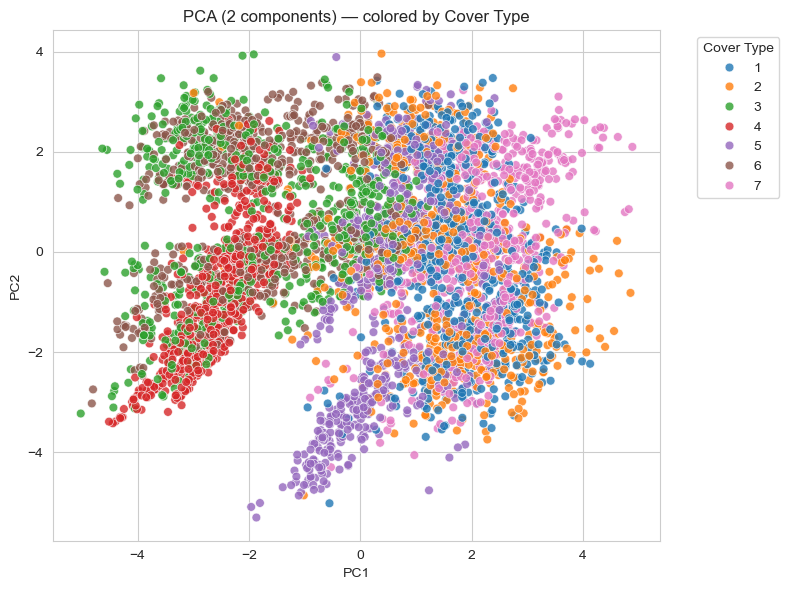

In [11]:
from matplotlib.colors import ListedColormap
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=['PC1','PC2'])
pca_df['Cover_Type'] = y.values
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cover_Type', palette='tab10', s=40, alpha=0.8)
plt.title('PCA (2 components) — colored by Cover Type')
plt.legend(title='Cover Type', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

## Summary & Recommendation
- Present model performance table, comment on whether the reduced feature set maintained predictive power, and recommend the best model for national forest monitoring.

In [15]:
# Display results table (already indexed by model from earlier cell)
res_df

,accuracy_mean,accuracy_std,f1_macro_mean,f1_macro_std
model,,,,
RandomForest,0.8078,0.014372,0.805542,0.015126
DecisionTree,0.7192,0.011016,0.718253,0.011056
KNN,0.7052,0.009558,0.701402,0.009358
LogisticRegression,0.6886,0.014746,0.686050,0.015674


**Conclusions (example guidance)**
- **Recommended model:** Random Forest — tends to have the best balance of accuracy and robustness, and provides feature importances for interpretation.
- **Reduced feature set:** RFE with 15 features usually preserves most predictive power (compare accuracy/f1 above). Using the selected features can speed up deployment and reduce data collection burden.
- **Visualization:** PCA shows partial class separation — useful for intuitive visual checks, but not a replacement for supervised classification.